In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tr

import torch_geometric
from torch_geometric.nn import global_mean_pool
from torch_geometric.data import Batch

from typing import Optional, Union

from torch import Tensor
from torch.nn import Linear
from torch_geometric.nn.conv import MessagePassing, GravNetConv
from torch_geometric.typing import OptTensor, PairOptTensor, PairTensor
from torch_scatter import scatter

from tqdm.notebook import tqdm

import numpy as np

import json
import math
import os
import time

import sklearn
import sklearn.metrics

import matplotlib
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
plt.rcParams.update({'font.size': 20})

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# VICReg loss function
def criterion(x, y, device='cuda', lmbd = 5e-3, u = 1, v= 1, epsilon = 1e-3):
    bs = x.size(0)
    emb = x.size(1)

    std_x = torch.sqrt(x.var(dim=0) + epsilon)
    std_y = torch.sqrt(y.var(dim=0) + epsilon)
    var_loss = torch.mean(F.relu(1 - std_x)) + torch.mean(F.relu(1 - std_y))

    invar_loss = F.mse_loss(x, y)

    xNorm = (x - x.mean(0)) / x.std(0)
    yNorm = (y - y.mean(0)) / y.std(0)
    crossCorMat = (xNorm.T@yNorm) / bs
    cross_loss = (crossCorMat*lmbd - torch.eye(emb, device=torch.device(device))*lmbd).pow(2).sum()

    loss = u*var_loss + v*invar_loss + cross_loss

    return loss

# CLIC

In [3]:
# load the clic dataset
import glob
all_files = glob.glob(f"../data/clic/data_*")

data = []
for f in all_files:
    data += torch.load(f"{f}")

In [4]:
print(f"num of clic events {len(data)}")

num of clic events 7260


In [5]:
loader = torch_geometric.loader.DataLoader(data, batch_size=1)
for batch in loader:
    print(f"A single event: \n {batch}")
    break

A single event: 
 Batch(x=[135, 8], ygen=[135, 5], ygen_id=[135], ycand=[135, 5], ycand_id=[135], batch=[135], ptr=[2])


In [6]:
# function that takes an event~Batch() and splits it into two Batch() objects representing the tracks/clusters
def distinguish_PFelements(batch):
    
    track_id = 0
    cluster_id = 1

    tracks = Batch(x = batch.x[batch.x[:,0]==track_id][:,1:].float(),   # remove the first input feature which is not needed anymore
                  ygen = batch.ygen[batch.x[:,0]==track_id],
                  ygen_id = batch.ygen_id[batch.x[:,0]==track_id],
                  ycand = batch.ycand[batch.x[:,0]==track_id],
                  ycand_id = batch.ycand_id[batch.x[:,0]==track_id],
                  batch = batch.batch[batch.x[:,0]==track_id],
                 )
    clusters = Batch(x = batch.x[batch.x[:,0]==cluster_id][:,1:].float(),   # remove the first input feature which is not needed anymore
                    ygen = batch.ygen[batch.x[:,0]==cluster_id],
                    ygen_id = batch.ygen_id[batch.x[:,0]==cluster_id],
                    ycand = batch.ycand[batch.x[:,0]==cluster_id],
                    ycand_id = batch.ycand_id[batch.x[:,0]==cluster_id],
                    batch = batch.batch[batch.x[:,0]==cluster_id],                    
                   )
    
    return tracks, clusters

# conversly, function that combines the learned latent representations back into one Batch() object
def combine_PFelements(tracks, clusters):
    
    event = Batch(x = torch.cat([tracks.x, clusters.x]),
                  ygen = torch.cat([tracks.ygen, clusters.ygen]),
                  ygen_id = torch.cat([tracks.ygen_id, clusters.ygen_id]),
                  ycand = torch.cat([tracks.ycand, clusters.ycand]),
                  ycand_id = torch.cat([tracks.ycand_id, clusters.ycand_id]),
                  batch = torch.cat([tracks.batch, clusters.batch]),
                 )
    
    return event

In [7]:
tracks, clusters = distinguish_PFelements(batch)

print(f"event:    {batch}")
print(f"tracks:   {tracks}")
print(f"clusters: {clusters}")

event:    Batch(x=[135, 8], ygen=[135, 5], ygen_id=[135], ycand=[135, 5], ycand_id=[135], batch=[135], ptr=[2])
tracks:   Batch(x=[43, 7], ygen=[43, 5], ygen_id=[43], ycand=[43, 5], ycand_id=[43], batch=[43])
clusters: Batch(x=[92, 7], ygen=[92, 5], ygen_id=[92], ycand=[92, 5], ycand_id=[92], batch=[92])


# VICreg

In [8]:
# define the Encoder that learns latent representations of tracks and clusters 
# these representations will be used by MLPF which is the downstream task
class Encoder(nn.Module):

    def __init__(
        self,
        input_dim=7,
        embedding_dim=34,
        num_convs=2,
    ):
        super(Encoder, self).__init__()

        self.act = nn.ELU

        ### 1. different embedding of tracks/clusters
        self.nn1 = nn.Sequential(
            nn.Linear(input_dim, 126),
            self.act(),
            nn.Linear(126, 126),
            self.act(),
            nn.Linear(126, embedding_dim),
        )
        self.nn2 = nn.Sequential(
            nn.Linear(input_dim, 126),
            self.act(),
            nn.Linear(126, 126),
            self.act(),
            nn.Linear(126, embedding_dim),
        )

        ### 2. same GNN for tracks/clusters
        self.conv = nn.ModuleList()
        for i in range(num_convs):
            self.conv.append(GravNetConv(embedding_dim, embedding_dim, 
                                         space_dimensions=4, 
                                         propagate_dimensions=22, 
                                         k=16))
        
    def forward(self, tracks, clusters):
  
        embedding_tracks = self.nn1(tracks.x.float())
        embedding_clusters = self.nn2(clusters.x.float())
        
        # perform a series of graph convolutions
        for num, conv in enumerate(self.conv):
            embedding_tracks = conv(embedding_tracks, tracks.batch)
            embedding_clusters = conv(embedding_clusters, clusters.batch)
        
        return embedding_tracks, embedding_clusters

In [9]:
# define the decoder that expands the latent representations of tracks and clusters 
class Decoder(nn.Module):

    def __init__(
        self,
        embedding_dim=34,
        output_dim=200,
    ):
        super(Decoder, self).__init__()

        self.act = nn.ELU
    
        ############################ DECODER
        self.expander = nn.Sequential(
            nn.Linear(embedding_dim, 126),
            self.act(),
            nn.Linear(126, 126),
            self.act(),
            nn.Linear(126, output_dim),
        )
        
    def forward(self, out_tracks, out_clusters):
        
        return self.expander(out_tracks), self.expander(out_clusters)

In [10]:
# retrieve a batch with batch_size>1
loader = torch_geometric.loader.DataLoader(data, batch_size=2)
for batch in loader:
    break

# retrieve the tracks and clusters
tracks, clusters = distinguish_PFelements(batch)

# setup VICReg
encoder = Encoder(embedding_dim=34)
decoder = Decoder(embedding_dim=34)

# make encoder forward pass
embedding_tracks, embedding_clusters = encoder(tracks, clusters)

# pooling
pooled_tracks = global_mean_pool(embedding_tracks, tracks.batch)     
pooled_clusters = global_mean_pool(embedding_clusters, clusters.batch)

# make decoder forward pass
out_tracks, out_clusters = decoder(pooled_tracks, pooled_clusters)

# compute the loss between the two latent representations
loss = criterion(out_tracks, out_clusters, device='cpu')
print('loss is: ', loss.item())

loss is:  3.007838487625122


In [20]:
# train the encoder
def train_VICReg(encoder, decoder, data, batch_size, lr, epochs):
    
    data_train = data[:4000]
    data_valid = data[4000:5000]

    train_loader = torch_geometric.loader.DataLoader(data_train, batch_size)
    valid_loader = torch_geometric.loader.DataLoader(data_valid, batch_size)    
    
    optimizer = torch.optim.SGD(list(encoder.parameters()) + list(decoder.parameters()), 
                                lr=lr, 
                                momentum= 0.9, 
                                weight_decay=1.5e-4
                               )

    patience = 20
    best_val_loss = 99999.9
    stale_epochs = 0

    losses_train, losses_valid = [], []
    
    for epoch in tqdm(range(epochs)):

        encoder.train()
        decoder.train()
        loss_train = 0
        
        for batch in tqdm(train_loader):
            # make transformation
            tracks, clusters = distinguish_PFelements(batch)

            ### ENCODE
            embedding_tracks, embedding_clusters = encoder(tracks, clusters)
            ### POOLING
            pooled_tracks = global_mean_pool(embedding_tracks, tracks.batch)     
            pooled_clusters = global_mean_pool(embedding_clusters, clusters.batch)
            ### DECODE
            out_tracks, out_clusters = decoder(pooled_tracks, pooled_clusters)

            # compute loss
            loss = criterion(out_tracks, out_clusters, device='cpu')
            
            # update parameters
            for param in encoder.parameters():
                param.grad = None
            for param in decoder.parameters():
                param.grad = None                
            loss.backward()
            optimizer.step()

            loss_train += loss.detach()
        
        encoder.eval()
        decoder.eval()
        loss_valid = 0
        with torch.no_grad():
            for batch in tqdm(valid_loader):
                # make transformation
                tracks, clusters = distinguish_PFelements(batch)

                ### ENCODE
                embedding_tracks, embedding_clusters = encoder(tracks, clusters)
                ### POOLING
                pooled_tracks = global_mean_pool(embedding_tracks, tracks.batch)     
                pooled_clusters = global_mean_pool(embedding_clusters, clusters.batch)
                ### DECODE
                out_tracks, out_clusters = decoder(pooled_tracks, pooled_clusters)

                # compute loss
                loss = criterion(out_tracks, out_clusters, device='cpu')
                
                loss_valid += loss.detach()
                
        print(f"epoch {epoch} - loss_train: {round(loss_train.item(),3)} - loss_valid: {round(loss_valid.item(),3)}")

        losses_train.append(loss_train/len(train_loader)) 
        losses_valid.append(loss_valid/len(valid_loader)) 

    return losses_train, losses_valid

In [21]:
batch_size = 100
lr = 1e-3
encoder = Encoder(embedding_dim=34)
decoder = Decoder(embedding_dim=34)
losses_train_VICRreg, losses_valid_VICRreg = train_VICReg(encoder, decoder, data, batch_size, lr, epochs=100)


epoch 0 - loss_train: 79.739 - loss_valid: 17.87



epoch 1 - loss_train: 71.071 - loss_valid: 17.666



epoch 2 - loss_train: 70.605 - loss_valid: 17.589



epoch 3 - loss_train: 70.363 - loss_valid: 17.542



epoch 4 - loss_train: 70.189 - loss_valid: 17.51



epoch 5 - loss_train: 70.053 - loss_valid: 17.487



epoch 6 - loss_train: 69.945 - loss_valid: 17.47



epoch 7 - loss_train: 69.857 - loss_valid: 17.456



epoch 8 - loss_train: 69.785 - loss_valid: 17.444



epoch 9 - loss_train: 69.724 - loss_valid: 17.434



epoch 10 - loss_train: 69.672 - loss_valid: 17.425



epoch 11 - loss_train: 69.627 - loss_valid: 17.417



epoch 12 - loss_train: 69.588 - loss_valid: 17.41



epoch 13 - loss_train: 69.553 - loss_valid: 17.404



epoch 14 - loss_train: 69.522 - loss_valid: 17.399



epoch 15 - loss_train: 69.494 - loss_valid: 17.394



epoch 16 - loss_train: 69.467 - loss_valid: 17.389



epoch 17 - loss_train: 69.443 - loss_valid: 17.385



epoch 18 - loss_train: 69.421 - loss_valid: 17.381



epoch 19 - loss_train: 69.399 - loss_valid: 17.377



epoch 20 - loss_train: 69.379 - loss_valid: 17.373



epoch 21 - loss_train: 69.359 - loss_valid: 17.369



epoch 22 - loss_train: 69.339 - loss_valid: 17.365



epoch 23 - loss_train: 69.32 - loss_valid: 17.361



epoch 24 - loss_train: 69.3 - loss_valid: 17.357



epoch 25 - loss_train: 69.281 - loss_valid: 17.353



epoch 26 - loss_train: 69.261 - loss_valid: 17.349



epoch 27 - loss_train: 69.241 - loss_valid: 17.344



epoch 28 - loss_train: 69.221 - loss_valid: 17.339



epoch 29 - loss_train: 69.2 - loss_valid: 17.334



epoch 30 - loss_train: 69.179 - loss_valid: 17.329



epoch 31 - loss_train: 69.157 - loss_valid: 17.323



epoch 32 - loss_train: 69.133 - loss_valid: 17.318



epoch 33 - loss_train: 69.105 - loss_valid: 17.314



epoch 34 - loss_train: 69.072 - loss_valid: 17.311



epoch 35 - loss_train: 69.031 - loss_valid: 17.31



epoch 36 - loss_train: 68.982 - loss_valid: 17.304



epoch 37 - loss_train: 68.927 - loss_valid: 17.292



epoch 38 - loss_train: 68.869 - loss_valid: 17.277



epoch 39 - loss_train: 68.809 - loss_valid: 17.256



epoch 40 - loss_train: 68.739 - loss_valid: 17.22



epoch 41 - loss_train: 68.636 - loss_valid: 17.187



epoch 42 - loss_train: 68.506 - loss_valid: 17.164



epoch 43 - loss_train: 68.383 - loss_valid: 17.126



epoch 44 - loss_train: 68.189 - loss_valid: 17.059



epoch 45 - loss_train: 67.945 - loss_valid: 17.026



epoch 46 - loss_train: 67.632 - loss_valid: 16.903



epoch 47 - loss_train: 67.262 - loss_valid: 16.804



epoch 48 - loss_train: 67.001 - loss_valid: 16.661



epoch 49 - loss_train: 66.515 - loss_valid: 16.515



epoch 50 - loss_train: 66.072 - loss_valid: 16.45



epoch 51 - loss_train: 65.402 - loss_valid: 16.125



epoch 52 - loss_train: 64.179 - loss_valid: 15.854



epoch 53 - loss_train: 63.728 - loss_valid: 15.652



epoch 54 - loss_train: 62.399 - loss_valid: 15.308



epoch 55 - loss_train: 60.877 - loss_valid: 15.14



epoch 56 - loss_train: 59.868 - loss_valid: 14.939



epoch 57 - loss_train: 61.403 - loss_valid: 15.098



epoch 58 - loss_train: 58.545 - loss_valid: 14.618



epoch 59 - loss_train: 57.321 - loss_valid: 14.153



epoch 60 - loss_train: 57.156 - loss_valid: 14.026



epoch 61 - loss_train: 55.431 - loss_valid: 13.815



epoch 62 - loss_train: 55.57 - loss_valid: 13.711



epoch 63 - loss_train: 54.121 - loss_valid: 13.445



epoch 64 - loss_train: 54.554 - loss_valid: 13.525



epoch 65 - loss_train: 53.189 - loss_valid: 13.48



epoch 66 - loss_train: 53.206 - loss_valid: 13.116



epoch 67 - loss_train: 52.09 - loss_valid: 13.147



epoch 68 - loss_train: 51.999 - loss_valid: 12.97



epoch 69 - loss_train: 51.021 - loss_valid: 12.885



epoch 70 - loss_train: 51.06 - loss_valid: 12.849



epoch 71 - loss_train: 50.34 - loss_valid: 12.631



epoch 72 - loss_train: 50.242 - loss_valid: 12.595



epoch 73 - loss_train: 49.277 - loss_valid: 12.496



epoch 74 - loss_train: 49.009 - loss_valid: 12.441



epoch 75 - loss_train: 48.742 - loss_valid: 12.341



epoch 76 - loss_train: 48.12 - loss_valid: 12.233



epoch 77 - loss_train: 48.255 - loss_valid: 12.215



epoch 78 - loss_train: 47.874 - loss_valid: 12.11



epoch 79 - loss_train: 47.47 - loss_valid: 12.027



epoch 80 - loss_train: 47.209 - loss_valid: 11.987



epoch 81 - loss_train: 47.755 - loss_valid: 11.989



epoch 82 - loss_train: 49.099 - loss_valid: 12.097



epoch 83 - loss_train: 46.353 - loss_valid: 11.865



epoch 84 - loss_train: 47.824 - loss_valid: 12.062



epoch 85 - loss_train: 46.226 - loss_valid: 11.856



epoch 86 - loss_train: 46.038 - loss_valid: 11.805



epoch 87 - loss_train: 46.061 - loss_valid: 11.849



epoch 88 - loss_train: 46.002 - loss_valid: 11.809



epoch 89 - loss_train: 45.816 - loss_valid: 11.891



epoch 90 - loss_train: 46.216 - loss_valid: 12.057



epoch 91 - loss_train: 46.714 - loss_valid: 11.91



epoch 92 - loss_train: 45.435 - loss_valid: 11.768



epoch 93 - loss_train: 45.894 - loss_valid: 11.767



epoch 94 - loss_train: 46.716 - loss_valid: 12.722



epoch 95 - loss_train: 46.932 - loss_valid: 12.906



epoch 96 - loss_train: 46.536 - loss_valid: 12.166



epoch 97 - loss_train: 45.694 - loss_valid: 12.089



epoch 98 - loss_train: 45.322 - loss_valid: 12.057



epoch 99 - loss_train: 45.268 - loss_valid: 12.135



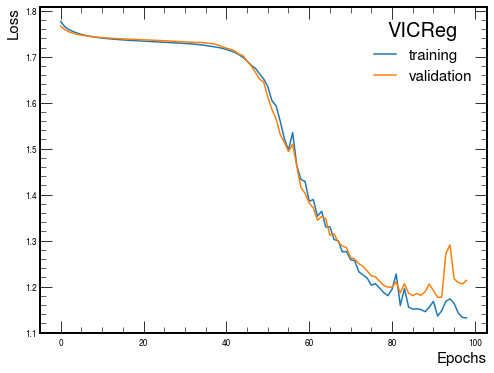

In [22]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(range(len(losses_train_VICRreg[1:])), losses_train_VICRreg[1:], label="training")
ax.plot(range(len(losses_valid_VICRreg[1:])), losses_valid_VICRreg[1:], label="validation")
ax.set_xlabel("Epochs", fontsize=15)
ax.set_ylabel("Loss", fontsize=15)
ax.legend(title='VICReg', loc="best", title_fontsize=20, fontsize=15);

# Train MLPF

In [23]:
class MLPF(nn.Module):
    def __init__(
        self,
        input_dim=7 + 34 + 200,
        embedding_dim = 34,
        num_classes=6,
        num_convs=2,
        k=8,
    ):
        super(MLPF, self).__init__()

        self.act = nn.ELU

        # GNN that uses the embeddings learnt by VICReg as the input features
        self.conv = nn.ModuleList()
        for i in range(num_convs):
            self.conv.append(GravNetConv(input_dim, input_dim, 
                                         space_dimensions=4, 
                                         propagate_dimensions=22, 
                                         k=k))

        # DNN that acts on the node level to predict the PID
        self.nn = nn.Sequential(
            nn.Linear(input_dim, 126),
            self.act(),
            nn.Linear(126, 126),
            self.act(),
            nn.Linear(126, num_classes),
        )

    def forward(self, batch):

        # unfold the Batch object
        input_ = batch.x.float()
        batch = batch.batch

#         embedding = self.nn0(input_)
        # perform a series of graph convolutions
        for num, conv in enumerate(self.conv):
            embedding = conv(input_, batch)

        # predict the PIDs
        preds_id = self.nn(embedding)

        return preds_id

In [24]:
def compute_weights(target_ids, num_classes):
    """
    computes necessary weights to accomodate class imbalance in the loss function
    """

    vs, cs = torch.unique(target_ids, return_counts=True)
    weights = torch.zeros(num_classes)
    for k, v in zip(vs, cs):
        weights[k] = 1.0 / math.sqrt(float(v))
    # weights[2] = weights[2] * 3  # emphasize nhadrons
    return weights

def train_mlpf(data, batch_size, model, with_VICReg, epochs):
        
    data_train = data[:4000]
    data_val = data[4000:5000]
    data_test = data[5000:]

    train_loader = torch_geometric.loader.DataLoader(data_train, batch_size)
    val_loader = torch_geometric.loader.DataLoader(data_val, batch_size)
    test_loader = torch_geometric.loader.DataLoader(data_test, batch_size)
    
    lr = 1e-3
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)#, momentum= 0.9, weight_decay=1.5e-4)

    patience = 20
    best_val_loss = 99999.9
    stale_epochs = 0

    losses_train, losses_valid = [], []

    encoder.eval()
    decoder.eval()    

    for epoch in tqdm(range(epochs)):

        model.train()
        loss_train = 0
        for batch in tqdm(train_loader):
            if with_VICReg:
                # make transformation
                tracks, clusters = distinguish_PFelements(batch)

                ### ENCODE
                embedding_tracks, embedding_clusters = encoder(tracks, clusters)
                ### POOLING
                pooled_tracks = global_mean_pool(embedding_tracks, tracks.batch)     
                pooled_clusters = global_mean_pool(embedding_clusters, clusters.batch)
                ### DECODE
                out_tracks, out_clusters = decoder(pooled_tracks, pooled_clusters)
      
                # use the learnt representation as your input as well as the global feature vector
                tracks.x = torch.cat([tracks.x, embedding_tracks, out_tracks[tracks.batch]], axis=1)
                clusters.x = torch.cat([clusters.x, embedding_clusters, out_clusters[clusters.batch]], axis=1)

                event = combine_PFelements(tracks, clusters)

            else:
                event = batch
                
            # make mlpf forward pass
            pred_ids_one_hot = model(event)
            pred_ids = torch.argmax(pred_ids_one_hot, axis=1)
            target_ids = event.ygen_id

            weights = compute_weights(target_ids, num_classes=6)  # to accomodate class imbalance
            loss = torch.nn.functional.cross_entropy(pred_ids_one_hot, target_ids, weight=weights)  # for classifying PID

            # update parameters
            for param in model.parameters():
                param.grad = None
            loss.backward()
            optimizer.step()

            loss_train += loss.detach()


        model.eval()
        loss_valid = 0
        with torch.no_grad():
            for batch in tqdm(val_loader):
                if with_VICReg:            
                    # make transformation
                    tracks, clusters = distinguish_PFelements(batch)

                    ### ENCODE
                    embedding_tracks, embedding_clusters = encoder(tracks, clusters)
                    ### POOLING
                    pooled_tracks = global_mean_pool(embedding_tracks, tracks.batch)     
                    pooled_clusters = global_mean_pool(embedding_clusters, clusters.batch)
                    ### DECODE
                    out_tracks, out_clusters = decoder(pooled_tracks, pooled_clusters)
      
                    # use the learnt representation as your input as well as the global feature vector
                    tracks.x = torch.cat([tracks.x, embedding_tracks, out_tracks[tracks.batch]], axis=1)
                    clusters.x = torch.cat([clusters.x, embedding_clusters, out_clusters[clusters.batch]], axis=1)

                    event = combine_PFelements(tracks, clusters)

                else:
                    event = batch

                # make mlpf forward pass
                pred_ids_one_hot = model(event)
                pred_ids = torch.argmax(pred_ids_one_hot, axis=1)
                target_ids = event.ygen_id

                weights = compute_weights(target_ids, num_classes=6)  # to accomodate class imbalance
                loss = torch.nn.functional.cross_entropy(pred_ids_one_hot, target_ids, weight=weights)  # for classifying PID

                loss_valid += loss.detach()

        print(f"epoch {epoch} - train: {round(loss_train.item(),3)} - valid: {round(loss_valid.item(), 3)} - stale={stale_epochs}")

        losses_train.append(loss_train/len(train_loader)) 
        losses_valid.append(loss_valid/len(val_loader))

        # early-stopping
        if losses_valid[epoch] < best_val_loss:
            best_val_loss = losses_valid[epoch]
            stale_epochs = 0
        else:
            stale_epochs += 1
            
    fig, ax = plt.subplots()
    ax.plot(range(len(losses_train[1:])), losses_train[1:], label="training")
    ax.plot(range(len(losses_valid[1:])), losses_valid[1:], label="validation")
    ax.set_xlabel("Epochs", fontsize=15)
    ax.set_ylabel("Loss", fontsize=15)
    if with_VICReg:
        ax.legend(title='ssl MLPF', loc="best", title_fontsize=20, fontsize=15);
    else:
        ax.legend(title='native MLPF', loc="best", title_fontsize=20, fontsize=15);
    return losses_train, losses_valid

In [25]:
# train ssl version of MLPF
model_ssl = MLPF(7 + 34 + 200)
print("Num of model paramaters: ", sum(p.numel() for p in model_ssl.parameters() if p.requires_grad))

197692



epoch 0 - train: 133.567 - valid: 26.632 - stale=0



epoch 1 - train: 98.324 - valid: 23.204 - stale=0



epoch 2 - train: 90.095 - valid: 22.097 - stale=0



epoch 3 - train: 85.877 - valid: 21.047 - stale=0



epoch 4 - train: 82.79 - valid: 20.435 - stale=0



epoch 5 - train: 80.768 - valid: 20.017 - stale=0



epoch 6 - train: 79.345 - valid: 19.716 - stale=0



epoch 7 - train: 78.285 - valid: 19.489 - stale=0



epoch 8 - train: 77.455 - valid: 19.305 - stale=0



epoch 9 - train: 76.781 - valid: 19.158 - stale=0



epoch 10 - train: 76.25 - valid: 19.045 - stale=0



epoch 11 - train: 75.828 - valid: 18.95 - stale=0



epoch 12 - train: 75.471 - valid: 18.869 - stale=0



epoch 13 - train: 75.154 - valid: 18.797 - stale=0



epoch 14 - train: 74.876 - valid: 18.733 - stale=0



epoch 15 - train: 74.626 - valid: 18.675 - stale=0



epoch 16 - train: 74.406 - valid: 18.623 - stale=0



epoch 17 - train: 74.205 - valid: 18.576 - stale=0



epoch 18 - train: 74.021 - valid: 18.535 - stale=0



epoch 19 - train: 73.856 - valid: 18.496 - stale=0



epoch 20 - train: 73.701 - valid: 18.46 - stale=0



epoch 21 - train: 73.561 - valid: 18.427 - stale=0



epoch 22 - train: 73.432 - valid: 18.397 - stale=0



epoch 23 - train: 73.311 - valid: 18.368 - stale=0



epoch 24 - train: 73.197 - valid: 18.344 - stale=0



epoch 25 - train: 73.093 - valid: 18.32 - stale=0



epoch 26 - train: 72.995 - valid: 18.297 - stale=0



epoch 27 - train: 72.903 - valid: 18.275 - stale=0



epoch 28 - train: 72.816 - valid: 18.254 - stale=0



epoch 29 - train: 72.732 - valid: 18.235 - stale=0



epoch 30 - train: 72.654 - valid: 18.216 - stale=0



epoch 31 - train: 72.579 - valid: 18.2 - stale=0



epoch 32 - train: 72.506 - valid: 18.183 - stale=0



epoch 33 - train: 72.438 - valid: 18.167 - stale=0



epoch 34 - train: 72.371 - valid: 18.151 - stale=0



epoch 35 - train: 72.308 - valid: 18.135 - stale=0



epoch 36 - train: 72.246 - valid: 18.122 - stale=0



epoch 37 - train: 72.189 - valid: 18.107 - stale=0



epoch 38 - train: 72.132 - valid: 18.093 - stale=0



epoch 39 - train: 72.074 - valid: 18.08 - stale=0



epoch 40 - train: 72.019 - valid: 18.068 - stale=0



epoch 41 - train: 71.966 - valid: 18.056 - stale=0



epoch 42 - train: 71.915 - valid: 18.045 - stale=0



epoch 43 - train: 71.865 - valid: 18.033 - stale=0



epoch 44 - train: 71.813 - valid: 18.022 - stale=0



epoch 45 - train: 71.766 - valid: 18.012 - stale=0



epoch 46 - train: 71.718 - valid: 18.002 - stale=0



epoch 47 - train: 71.671 - valid: 17.992 - stale=0



epoch 48 - train: 71.624 - valid: 17.982 - stale=0



epoch 49 - train: 71.582 - valid: 17.972 - stale=0



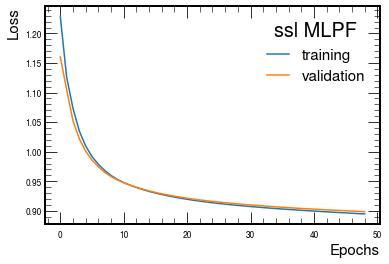

In [26]:
batch_size = 50
losses_train_ssl, losses_valid_ssl = train_mlpf(data, batch_size, model_ssl, with_VICReg=True, epochs=50)

In [27]:
class MLPF_native(nn.Module):
    def __init__(
        self,
        input_dim=7,
        embedding_dim=34,
        num_classes=6,
        num_convs=2,
        k=8,
    ):
        super(MLPF_native, self).__init__()

        self.act = nn.ELU
        
        # embedding
        self.nn0 = nn.Sequential(
            nn.Linear(input_dim, 280),
            self.act(),
            nn.Linear(280, 280),
            self.act(),
            nn.Linear(280, 280),
            self.act(),
            nn.Linear(280, embedding_dim),
        )
        
        # GNN that uses the embeddings learnt by VICReg as the input features
        self.conv = nn.ModuleList()
        for i in range(num_convs):
            self.conv.append(GravNetConv(embedding_dim, embedding_dim, 
                                         space_dimensions=4, 
                                         propagate_dimensions=22, 
                                         k=k))

        # DNN that acts on the node level to predict the PID
        self.nn = nn.Sequential(
            nn.Linear(embedding_dim, 126),
            self.act(),
            nn.Linear(126, 126),
            self.act(),
            nn.Linear(126, num_classes),
        )

    def forward(self, batch):

        # unfold the Batch object
        input_ = batch.x.float()
        batch = batch.batch

        # embedding
        embedding = self.nn0(input_)
        
        # perform a series of graph convolutions
        for num, conv in enumerate(self.conv):
            embedding = conv(embedding, batch)

        # predict the PIDs
        preds_id = self.nn(embedding)

        return preds_id

In [28]:
model_native = MLPF_native(input_dim=8)
print("Num of model paramaters: ", sum(p.numel() for p in model_native.parameters() if p.requires_grad))

197800



epoch 0 - train: 108.824 - valid: 26.004 - stale=0



epoch 1 - train: 102.89 - valid: 25.506 - stale=0



epoch 2 - train: 101.132 - valid: 25.1 - stale=0



epoch 3 - train: 99.549 - valid: 24.71 - stale=0



epoch 4 - train: 97.984 - valid: 24.316 - stale=0



epoch 5 - train: 96.375 - valid: 23.905 - stale=0



epoch 6 - train: 94.683 - valid: 23.47 - stale=0



epoch 7 - train: 92.885 - valid: 23.007 - stale=0



epoch 8 - train: 90.967 - valid: 22.513 - stale=0



epoch 9 - train: 88.937 - valid: 21.996 - stale=0



epoch 10 - train: 86.841 - valid: 21.472 - stale=0



epoch 11 - train: 84.777 - valid: 20.972 - stale=0



epoch 12 - train: 82.87 - valid: 20.527 - stale=0



epoch 13 - train: 81.227 - valid: 20.156 - stale=0



epoch 14 - train: 79.896 - valid: 19.864 - stale=0



epoch 15 - train: 78.864 - valid: 19.642 - stale=0



epoch 16 - train: 78.085 - valid: 19.475 - stale=0



epoch 17 - train: 77.498 - valid: 19.348 - stale=0



epoch 18 - train: 77.049 - valid: 19.25 - stale=0



epoch 19 - train: 76.693 - valid: 19.171 - stale=0



epoch 20 - train: 76.402 - valid: 19.105 - stale=0



epoch 21 - train: 76.153 - valid: 19.048 - stale=0



epoch 22 - train: 75.935 - valid: 18.997 - stale=0



epoch 23 - train: 75.738 - valid: 18.951 - stale=0



epoch 24 - train: 75.556 - valid: 18.908 - stale=0



epoch 25 - train: 75.385 - valid: 18.867 - stale=0



epoch 26 - train: 75.223 - valid: 18.829 - stale=0



epoch 27 - train: 75.069 - valid: 18.792 - stale=0



epoch 28 - train: 74.921 - valid: 18.757 - stale=0



epoch 29 - train: 74.779 - valid: 18.722 - stale=0



epoch 30 - train: 74.641 - valid: 18.689 - stale=0



epoch 31 - train: 74.508 - valid: 18.657 - stale=0



epoch 32 - train: 74.38 - valid: 18.626 - stale=0



epoch 33 - train: 74.256 - valid: 18.596 - stale=0



epoch 34 - train: 74.138 - valid: 18.567 - stale=0



epoch 35 - train: 74.025 - valid: 18.539 - stale=0



epoch 36 - train: 73.918 - valid: 18.512 - stale=0



epoch 37 - train: 73.817 - valid: 18.485 - stale=0



epoch 38 - train: 73.722 - valid: 18.46 - stale=0



epoch 39 - train: 73.631 - valid: 18.436 - stale=0



epoch 40 - train: 73.543 - valid: 18.414 - stale=0



epoch 41 - train: 73.458 - valid: 18.392 - stale=0



epoch 42 - train: 73.375 - valid: 18.371 - stale=0



epoch 43 - train: 73.295 - valid: 18.352 - stale=0



epoch 44 - train: 73.218 - valid: 18.333 - stale=0



epoch 45 - train: 73.147 - valid: 18.316 - stale=0



epoch 46 - train: 73.077 - valid: 18.299 - stale=0



epoch 47 - train: 73.01 - valid: 18.284 - stale=0



epoch 48 - train: 72.947 - valid: 18.268 - stale=0



epoch 49 - train: 72.885 - valid: 18.254 - stale=0



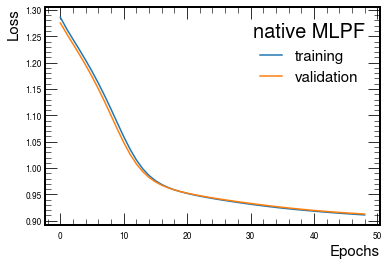

In [29]:
# train native MLPF
batch_size = 50
losses_train_native, losses_valid_native = train_mlpf(data, batch_size, model_native, with_VICReg=False, epochs=50)

## Compare native vs SSL

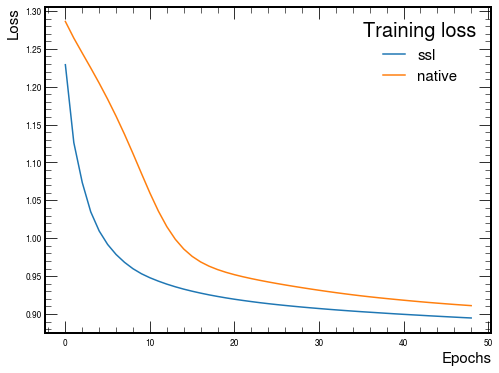

In [32]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(range(len(losses_train_ssl[1:])), losses_train_ssl[1:], label="ssl")
ax.plot(range(len(losses_train_native[1:])), losses_train_native[1:], label="native")
ax.set_xlabel("Epochs", fontsize=15)
ax.set_ylabel("Loss", fontsize=15)
ax.legend(title='Training loss', loc="best", title_fontsize=20, fontsize=15);

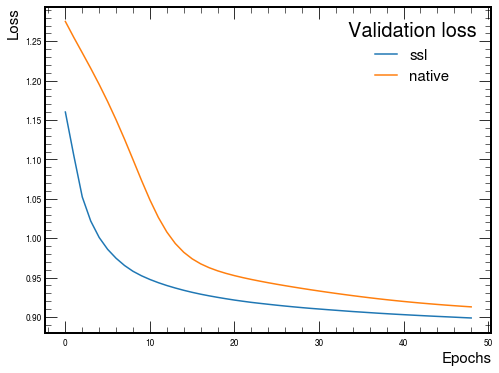

In [33]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(range(len(losses_valid_ssl[1:])), losses_valid_ssl[1:], label="ssl")
ax.plot(range(len(losses_valid_native[1:])), losses_valid_native[1:], label="native")
ax.set_xlabel("Epochs", fontsize=15)
ax.set_ylabel("Loss", fontsize=15)
ax.legend(title='Validation loss', loc="best", title_fontsize=20, fontsize=15);

## Evaluate the SSL against native MLPF

In [34]:
def evaluate_mlpf(model, with_VICReg):
    num_classes = 6
    conf_matrix = np.zeros((num_classes, num_classes))

    model.eval()
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        for i, batch in tqdm(enumerate(test_loader)):
            if with_VICReg:
                 # make transformation
                tracks, clusters = distinguish_PFelements(batch)

                ### ENCODE
                embedding_tracks, embedding_clusters = encoder(tracks, clusters)
                ### POOLING
                pooled_tracks = global_mean_pool(embedding_tracks, tracks.batch)     
                pooled_clusters = global_mean_pool(embedding_clusters, clusters.batch)
                ### DECODE
                out_tracks, out_clusters = decoder(pooled_tracks, pooled_clusters)
      
                # use the learnt representation as your input as well as the global feature vector
                tracks.x = torch.cat([tracks.x, embedding_tracks, out_tracks[tracks.batch]], axis=1)
                clusters.x = torch.cat([clusters.x, embedding_clusters, out_clusters[clusters.batch]], axis=1)

                event = combine_PFelements(tracks, clusters)

            else:
                event = batch

            # make mlpf forward pass
            pred_ids_one_hot = model(event)
            pred_ids = torch.argmax(pred_ids_one_hot, axis=1)
            target_ids = event.ygen_id

            conf_matrix += sklearn.metrics.confusion_matrix(
                target_ids.detach().cpu(), pred_ids.detach().cpu(), labels=range(num_classes)
            )
    return conf_matrix

CLASS_NAMES_CLIC_LATEX = ["none", "chhad", "nhad", "$\gamma$", "$e^\pm$", "$\mu^\pm$"]

def plot_conf_matrix(cm, title):
    import itertools

    cmap = plt.get_cmap("Blues")
    cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    cm[np.isnan(cm)] = 0.0

    fig = plt.figure(figsize=(8, 6))

    ax = plt.axes()
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.colorbar()

    thresh = cm.max() / 1.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            "{:0.2f}".format(cm[i, j]),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black", fontsize=15
        )
    plt.title(title, fontsize=25)
    plt.xlabel("Predicted label", fontsize=15)
    plt.ylabel("True label", fontsize=15)

    plt.xticks(range(len(CLASS_NAMES_CLIC_LATEX)), CLASS_NAMES_CLIC_LATEX, rotation=45, fontsize=15)
    plt.yticks(range(len(CLASS_NAMES_CLIC_LATEX)), CLASS_NAMES_CLIC_LATEX, fontsize=15)

    plt.tight_layout()

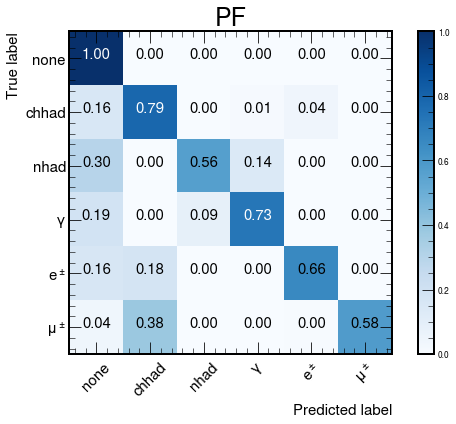

In [35]:
# make confusion matrix of PF for comparison
batch_size = 50

num_classes = 6
conf_matrix_pf = np.zeros((num_classes, num_classes))

test_loader = torch_geometric.loader.DataLoader(data[5000:], batch_size)   
for i, batch in tqdm(enumerate(test_loader)):

    # make mlpf forward pass
    target_ids = batch.ygen_id
    pred_ids = batch.ycand_id
    
    conf_matrix_pf += sklearn.metrics.confusion_matrix(
        target_ids.detach().cpu(), pred_ids.detach().cpu(), labels=range(num_classes)
    )
plot_conf_matrix(conf_matrix_pf, 'PF')

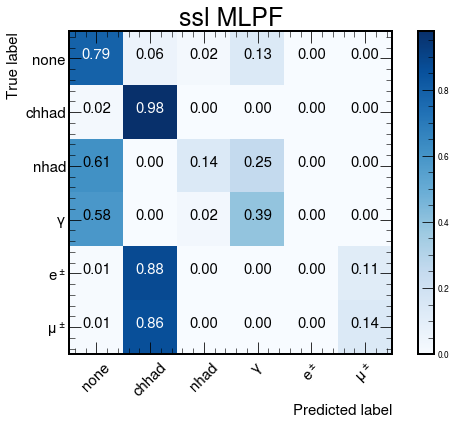

In [36]:
batch_size = 100
conf_matrix_ssl = evaluate_mlpf(model_ssl, with_VICReg=True)
plot_conf_matrix(conf_matrix_ssl, 'ssl MLPF')

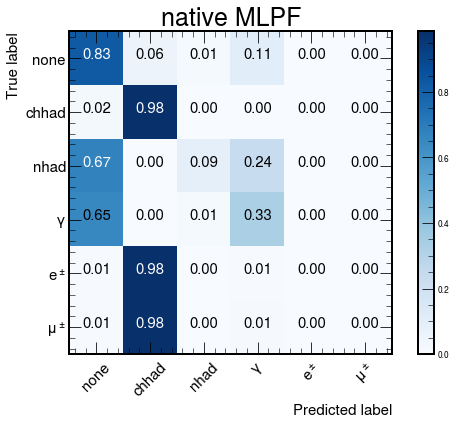

In [37]:
conf_matrix = evaluate_mlpf(model_native, with_VICReg=False)
plot_conf_matrix(conf_matrix, 'native MLPF')

In [38]:
print("Num of ssl mlpf model paramaters: ", sum(p.numel() for p in model_ssl.parameters() if p.requires_grad))

Num of ssl mlpf model paramaters:  197692


In [39]:
print("Num of native mlpf model paramaters: ", sum(p.numel() for p in model_native.parameters() if p.requires_grad))

Num of native mlpf model paramaters:  197800
